## Select articles: look for hateful comments

In [38]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-selection")
db = client["hatespeech-selection"]

Article.objects.count()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


68896

Acá tomamos a partir del 1ro de marzo...

In [39]:
import datetime

start_date = datetime.datetime(2020, 3, 1)

base_query = {
    "dummy__ne": True,
    "comments__19__exists": True,
    "created_at__gte": start_date,
}

Article.objects(**base_query).count()

10314

In [40]:
import random
from mongoengine import DoesNotExist
from hatespeech_models import Reply
from collections import defaultdict

comment_seeds = [
    # Mujer
    "bija",
    "\"prostituta\"",
    #"\"trola\"",
    "feministas",
    "feminazis",
    "aborteras",
    #"\"boluda\" -\"gente\"",
    #"\"puta\"",
    #"\"gato\"",
    "\"urraca\"",
    "tucán",
    "\"putita\"",
    "\"reventada\"",

    # LGBTI
    "marica",
    "\"viejo puto\"",    
    "\"trabuco\"",
    "travesti",
    "\"trava\"",
    "\"degenerado\"",
    
    #"\"puto\"",
    "trolo -\"no seas\" -\"no sean\"",
    "\"sodomita\"",
    
    # Xenofobia, Racismo, Religión
    #"\"chinos de\"",
    "\"chinos\"",
    "bolita",
    # Lo pongo así porque "Paraguay" lo usan contra macri
    "\"paraguayo\"",
    "\"peruano\"",
    "\"peruca\"",
    "judío",
    
    "\"jude\"",
    "sionista",
    "\"matarlos\"",
    "\"una bomba\"",
    
    # Pobreza/Racismo
    
    "\"vayan a laburar\"",
    "\"vayan a trabajar\"",
   "\"planero\"",
    "\"villeros\"",
    "\"negra\" -guita -plata -lagrima -peste -alma",
    "\"negro de\"",
    "\"negros\"",
    # Política
    
    # No ponemos ninguno!
    # Violentos
    "\"bala\"",
    "\"uno menos\"",
    # Aspecto
    "\"gorda\"",
]

new_article_ids = set()

votes = defaultdict(list)
reason = {}
seed_articles = {}

for word in comment_seeds:
    nuevos = 0
    limit = None
    if type(word) is tuple:
        word, limit = word
    """
    for _ in range(3):
        print("="*80)
        
    print(f"\n\n{word}\n\n")
    """
    replies = Reply.objects.no_dereference().search_text(word)
    article_ids = [rep.article.id for rep in replies]
    articles = Article.objects(id__in=article_ids, **base_query)
    total_count = articles.count()
    
    for rep in replies:
        votes[rep.article.id].append(word)
    
    for article in articles:
        try:
            if article.id not in seed_articles:
                nuevos += 1
                seed_articles[article.id] = article
                reason[article.id] = f"Comment -- {word} ({word})"
                if limit and nuevos >= limit:
                    break
            else:
                pass
                #print(f"\nSkipping {article} -- Reason: {reason[article.id]}")
        except DoesNotExist as e:
            pass
            #print(f"\nSkipping {Article.objects.get(id=rep.article.id)} -- {e}")

    print(f"{word[:30]:<30} ---> {nuevos:<4} nuevos/ {total_count:<5} total comentarios --> {len(seed_articles):<5} artículos al momento", end="")
    
    if limit:
        print(f" (limitados a {limit})")
    else:
        print("")


bija                           ---> 47   nuevos/ 47    total comentarios --> 47    artículos al momento
"prostituta"                   ---> 146  nuevos/ 148   total comentarios --> 193   artículos al momento
feministas                     ---> 270  nuevos/ 301   total comentarios --> 463   artículos al momento
feminazis                      ---> 46   nuevos/ 86    total comentarios --> 509   artículos al momento
aborteras                      ---> 110  nuevos/ 159   total comentarios --> 619   artículos al momento
"urraca"                       ---> 55   nuevos/ 65    total comentarios --> 674   artículos al momento
tucán                          ---> 66   nuevos/ 96    total comentarios --> 740   artículos al momento
"putita"                       ---> 23   nuevos/ 40    total comentarios --> 763   artículos al momento
"reventada"                    ---> 45   nuevos/ 66    total comentarios --> 808   artículos al momento
marica                         ---> 54   nuevos/ 69    total com

Redujimos bastante los comentarios complicados

Quedó 

- chinos (con 638)

Cambiamos negros por otras variantes

In [41]:
len(seed_articles)

3985

Cantidad artículos con más de 2 votos : 2544
Cantidad artículos con más de 3 votos : 1408
Cantidad artículos con más de 4 votos : 950
Cantidad artículos con más de 5 votos : 681
Cantidad artículos con más de 6 votos : 520
Cantidad artículos con más de 7 votos : 420
Cantidad artículos con más de 8 votos : 356
Cantidad artículos con más de 9 votos : 291


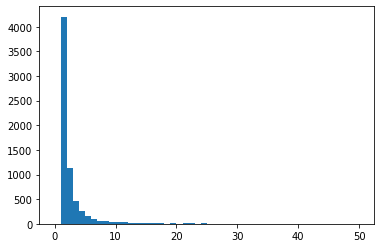

In [42]:
import matplotlib.pyplot as plt

for k in range(2, 10):
    count = 0
    for _, v in votes.items():
        if len(v) >= k:
            count += 1
    print(f"Cantidad artículos con más de {k} votos : {count}")

plt.hist([len(v) for v in votes.values()], bins=50, range=[0, 50]);


Me quedo sólo con los artículos que tengan al menos 2 votos

In [43]:
selected_articles = {k: v for k, v in votes.items() if len(v) >= 2}
selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)

selected_articles.count()

2089

Les pongo la descripción de su elección

In [44]:
Article.objects.update(set__description="")

68896

In [45]:
from tqdm.auto import tqdm
from collections import Counter

for article in tqdm(selected_articles):
    this_art_votes = votes[article.id]
    
    article.description = str(dict(Counter(this_art_votes)))
    article.save()

In [46]:
from groups.models import Group

def accept_article(art):
    politicians = ["Ginés", "Mauricio Macri", "Alberto Fernández", "Magario"]
    
    if any(p.lower() in art.title.lower() for p in politicians):
        return len(votes[art.id]) >= 5
    return True
    
    
for k in [2, 3, 4, 5]:
    try:
        group = Group.objects.get(name=f"Seed comments - {k} votes")
    except DoesNotExist:
        group = Group(name=f"Seed comments - {k} votes")
    selected_articles = {article_id: v for article_id, v in votes.items() if len(v) >= k}
    selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)
    selected_articles = [a for a in selected_articles if accept_article(a)]
    print(f"{k} votes -- {len(selected_articles)} articles")
    group.articles = selected_articles
    
    group.save()
    


2 votes -- 1865 articles
3 votes -- 1175 articles
4 votes -- 858 articles
5 votes -- 660 articles


In [47]:
group = Group.objects.no_dereference().get(name="Seed comments - 3 votes")

Antes 1189

In [48]:
article_ids = [a.id for a in group.articles]
Article.objects.update(set__selected=False)
updated = Article.objects(id__in=article_ids).update(set__selected=True)
print(f"Marcados como seleccionados {updated} artículos")

Marcados como seleccionados 1175 artículos


## Demo

Están los de demo?

In [49]:
demo_ids = [
  1253699106385481728,
  1242419653030313984,
  1275389016511336448,
  1310165736011239424,
  1254951309469519875
]

Article.objects(tweet_id__in=demo_ids, selected=True).count()

5

Perfecto!

Y los de train?

In [50]:
train_ids = [
    1247580175455444993,
    1296651850796732419,
    1242447731286777856,
    1263476271603998720,
    1255472854776393728,
    1296507657189314566,
    1275218345969831936,
    1263868365468135430,
    1300878739870539776,
    1294980385907015680,
    1293587848277434370,
    1238231799995736066,
    1304290690306891776,
    1277424269153239041,
    1308802398752854016,
    1273719287614787584,
    1281715363798036490,
    1296244483655454720,
    1265837173510672390,
    1249151575257481227,
    1312925607093776384,
    1314005353353314304,
    1243147648238059520,
    1273676406614978561,
    1302741866681491456
]

len(train_ids), Article.objects(tweet_id__in=train_ids, selected=True).count()

(25, 15)


Cuáles quedaron afuera?

Veamos los que quedaron

In [52]:

for art in Article.objects(tweet_id__in=train_ids, selected=True):
    print("="*80)
    print("- ", art.title)
    print(art.description)

-  Cecilia Roth: “La marcha anticuarentena me pareció una irresponsabilidad sanitaria”
{'aborteras': 1, '"reventada"': 1, 'trolo -"no seas" -"no sean"': 2, '"planero"': 1, '"bala"': 1, '"gorda"': 1}
-  Solo el 35,5% de la población aprueba la gestión de la pandemia realizada por el Gobierno
{'"planero"': 4}
-  Verónica Magario pidió endurecer la cuarentena: “Debemos frenar la circulación de personas en el AMBA para evitar contagios”
{'"prostituta"': 1, '"villeros"': 1, '"negra" -guita -plata -lagrima -peste -alma': 3}
-  Los piratas del siglo XXI se roban US$1000 millones por año del mar argentino
{'"chinos"': 2, '"planero"': 1, '"gorda"': 1}
-  Escándalo en España: fallan los tests de coronavirus fabricados en China
{'"chinos"': 8}
-  Florencia Peña se diferenció de los argentinos que se quieren ir del país: “Muchos queremos seguir apostando”
{'trolo -"no seas" -"no sean"': 1, '"bala"': 1, '"gorda"': 1}
-  El primer muerto en los motines de las cárceles de Santa Fe fue un barra de Col

In [53]:

for art in Article.objects(tweet_id__in=train_ids, selected=False):
    print("="*80)
    print("- ", art.title)
    print(art.description)

-  Ginés González García admite que prohibieron a los runners por una cuestión de imagen “más que por los contagios”
{'aborteras': 1, 'trolo -"no seas" -"no sean"': 2, '"gorda"': 1}
-  Según un experto italiano, “el coronavirus se está debilitando y podría morir solo sin una vacuna”

-  Coronavirus en la Argentina: Hebe de Bonafini pidió suspender la marcha del 24 de marzo
{'"chinos"': 1, '"negra" -guita -plata -lagrima -peste -alma': 1}
-  Al borde de las lágrimas, Luis Brandoni convocó un banderazo en contra del Gobierno, pero “cumpliendo todos los protocolos”

-  Cecilia Roth: "La marcha anticuarentena me pareció una irresponsabilidad sanitaria"

-  Ginés González: “La semana que viene aviones de Aerolíneas irán a China a buscar insumos de bioseguridad”

-  El proyecto del impuesto a la riqueza “está listo” y se presentará la próxima semana
{'"vayan a laburar"': 1, '"planero"': 1}
-  Ante el cierre de los cines por la pandemia el presidente del INCAA quiere ponerle otro impuesto a N